# All imports #

In [1]:
from __future__ import print_function

import sys, os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
import tensorflow.keras
import pandas as pd
import numpy as np
import sklearn
import keras
import csv

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout

from keras_uncertainty.models import MCDropoutClassifier, MCDropoutRegressor
from keras_uncertainty.utils import numpy_regression_nll


/home/dfki.uni-bremen.de/bmanickavasakan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dfki.uni-bremen.de/bmanickavasakan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dfki.uni-bremen.de/bmanickavasakan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/d

# Functions for csv files #

In [3]:
def load_joint_space_csv_chunks(file_path):
    data_frame = pd.read_csv(file_path, skiprows=1, header=None)
    del data_frame[18]
    return data_frame

def load_task_space_csv_chunks(file_path):
    return pd.read_csv(file_path, skiprows=1, header=None)


# Building the model with MC Droput #

In [7]:
TRAIN_FOLDER = '/home/dfki.uni-bremen.de/bmanickavasakan/newdataset_rh5_leg/leg_5steps/'
TEST_FOLDER = '/home/dfki.uni-bremen.de/bmanickavasakan/newdataset_rh5_leg/leg_5steps/test_4steps'

X_TRAIN_FILE = os.path.join(TRAIN_FOLDER, 'leg_forwardkinematics_x.csv')
Q_TRAIN_FILE = os.path.join(TRAIN_FOLDER, 'leg_sysstate_q.csv')

X_TEST_FILE = os.path.join(TEST_FOLDER, 'leg_forwardkinematics_x.csv')
Q_TEST_FILE = os.path.join(TEST_FOLDER, 'leg_sysstate_q.csv')

x_train = load_task_space_csv_chunks(X_TRAIN_FILE)
q_train = load_joint_space_csv_chunks(Q_TRAIN_FILE)

x_test = load_task_space_csv_chunks(X_TEST_FILE)
q_test = load_joint_space_csv_chunks(Q_TEST_FILE)

x_scaler = MinMaxScaler()
q_scaler = MinMaxScaler()

x_train = x_scaler.fit_transform(x_train)
q_train = q_scaler.fit_transform(q_train)

x_test = x_scaler.transform(x_test)
q_test = q_scaler.transform(q_test)



In [8]:
dropoutRate = 0.1

In [10]:
def model_builder(input_shape, output_shape):
    def build_model(depth, width, reduction_factor):
        model = Sequential()

        for i in range(depth):
            num_neurons = max(int(width * (reduction_factor ** i)), 4)
            if i == 0:
                model.add(Dense(num_neurons, activation='relu', input_shape=(input_shape,)))
            else:
                if i > 1:
                    model.add(Dropout(dropoutRate))
                model.add(Dense(num_neurons, activation='relu'))
                

            model.add(BatchNormalization())

        model.add(Dense(output_shape, activation='sigmoid'))

        model.compile(loss='mse', optimizer='adam', metrics=["mae"])

        return model
    return build_model

HYPERPARAMETERS = {'depth': 6, 'width': 64, 'reduction_factor':  0.9}

#with tf.device('/cpu:0'):
model = model_builder(9, 18)(**HYPERPARAMETERS)
hist = model.fit(x_train, q_train, epochs = 50, batch_size = 128, verbose = 1, validation_data=(x_test, q_test))
model.save("ik-rh5-leg-5steps.h5")

q_pred = model.predict(x_test, verbose=0)
q_unnorm = q_scaler.inverse_transform(q_test)
q_pred_unnorm = q_scaler.inverse_transform(q_pred)

global_mae = mean_absolute_error(q_test, q_pred)
#MAE without dropout mask
print("Testing MAE: {:.5f}".format(global_mae))

# Compute MAE for each output independently.
for i in range(q_test.shape[1]):
    norm_mae_i = mean_absolute_error(q_test[:, i], q_pred[:, i])
    mae_i = mean_absolute_error(q_unnorm[:, i], q_pred_unnorm[:, i])
    print("Q feature {} has unnorm MAE: {:.4f} (Range {:.4f} to {:.4f}) normalized MAE: {:.4f}".format(i, mae_i, q_scaler.data_min_[i], q_scaler.data_max_[i], norm_mae_i))


Train on 15625 samples, validate on 4096 samples
Epoch 1/50
15625/15625 [==============================] - 2s 110us/sample - loss: 0.0775 - mean_absolute_error: 0.2215 - val_loss: 0.0879 - val_mean_absolute_error: 0.2481
Epoch 2/50
15625/15625 [==============================] - 1s 45us/sample - loss: 0.0324 - mean_absolute_error: 0.1415 - val_loss: 0.0586 - val_mean_absolute_error: 0.1960
Epoch 3/50
15625/15625 [==============================] - 1s 45us/sample - loss: 0.0222 - mean_absolute_error: 0.1163 - val_loss: 0.0245 - val_mean_absolute_error: 0.1246
Epoch 4/50
15625/15625 [==============================] - 1s 44us/sample - loss: 0.0179 - mean_absolute_error: 0.1040 - val_loss: 0.0107 - val_mean_absolute_error: 0.0823
Epoch 5/50
15625/15625 [==============================] - 1s 44us/sample - loss: 0.0156 - mean_absolute_error: 0.0969 - val_loss: 0.0063 - val_mean_absolute_error: 0.0634
Epoch 6/50
15625/15625 [==============================] - 1s 44us/sample - loss: 0.0143 - mean_

15625/15625 [==============================] - 1s 43us/sample - loss: 0.0075 - mean_absolute_error: 0.0655 - val_loss: 0.0018 - val_mean_absolute_error: 0.0319
Epoch 49/50
15625/15625 [==============================] - 1s 45us/sample - loss: 0.0075 - mean_absolute_error: 0.0654 - val_loss: 0.0022 - val_mean_absolute_error: 0.0347
Epoch 50/50
15625/15625 [==============================] - 1s 46us/sample - loss: 0.0073 - mean_absolute_error: 0.0646 - val_loss: 0.0016 - val_mean_absolute_error: 0.0306
Testing MAE: 0.03057
Q feature 0 has unnorm MAE: 0.0546 (Range -0.7330 to 0.4398) normalized MAE: 0.0465
Q feature 1 has unnorm MAE: 0.0434 (Range -0.3840 to 0.5792) normalized MAE: 0.0451
Q feature 2 has unnorm MAE: 0.0247 (Range -0.8200 to -0.0680) normalized MAE: 0.0329
Q feature 3 has unnorm MAE: 0.0246 (Range -0.8381 to -0.0792) normalized MAE: 0.0324
Q feature 4 has unnorm MAE: 0.0027 (Range 0.0070 to 0.0907) normalized MAE: 0.0328
Q feature 5 has unnorm MAE: 0.0221 (Range 0.0000 to 1.

In [11]:
import matplotlib.pyplot as plt


epoch  = list(range(0, 20, 1))
#print(epoch)
#print(hist.history['loss'])
plt.figure()
plt.plot( epoch, hist.history['loss'],     label = 'Loss')
plt.plot( epoch, hist.history['mean_absolute_error'],      label = 'mean_absolute_error')
plt.plot( epoch, hist.history['val_loss'], label = 'val_loss')
plt.plot( epoch, hist.history['val_mean_absolute_error'],  label = 'val_mean_absolute_error')
plt.xlabel("Number of Epochs")
plt.ylabel("Error")
plt.legend(loc='upper right')


ValueError: x and y must have same first dimension, but have shapes (20,) and (50,)

# Regression, O/P : mean, Std #

In [12]:
#model = load_model('ik-rh5-leg-5steps.h5')

def test_mcdropout_regressor():   
    mc_model = MCDropoutRegressor(model)
    inp = x_test   
    
    mean, std = mc_model.predict(inp, num_samples = 10)
    
    '''
    print("shape of DF:", len(mean))
    print("single values in mean array:", mean[])
    print("shape of STD:", len(std))
    print("One-sample prediction mean: {}".format(mean))
    print("One-sample prediction std: {}".format(std))
    '''   
    
    q_pred_unnormalised = q_scaler.inverse_transform(mean)
    
    global_mae = mean_absolute_error(q_test, mean)
    
    #MAE MC droput 

    print("Testing MAE: {:.5f}".format(global_mae))

    return q_pred_unnormalised, std
  


mean, std = test_mcdropout_regressor()

print("NLL: {:.5f}".format(numpy_regression_nll(q_unnorm, mean, std**2)))

# Compute MAE for each output independently.
#for i in range(q_test.shape[1]):
#    mae_i = mean_absolute_error(q_unnorm[:, i], mean[:, i])


Testing MAE: 0.29063
NLL: 82.42762


In [7]:
sd_test = pd.DataFrame(std)

print(sd_test[0].min())

0.00010483763


/usr/lib/python3/dist-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


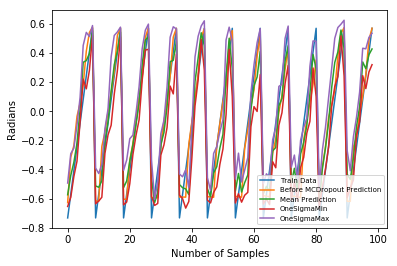

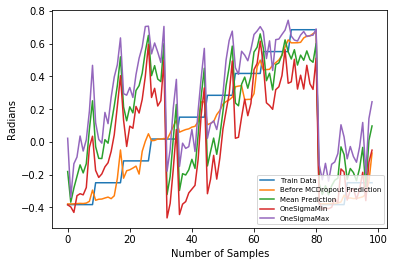

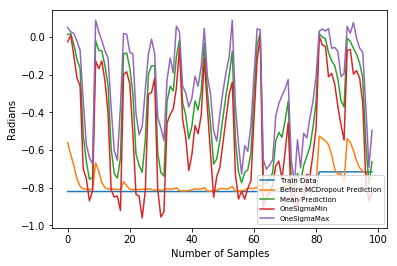

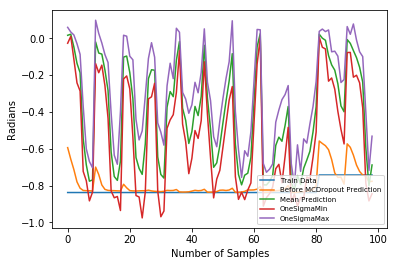

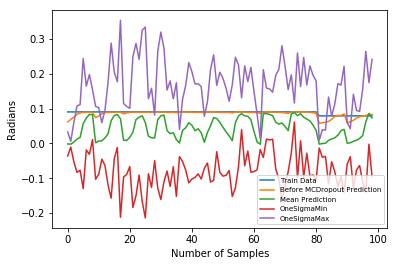

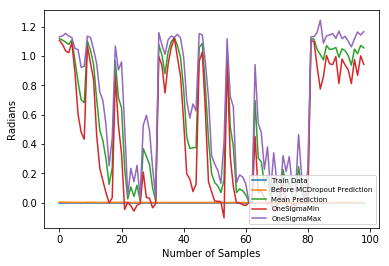

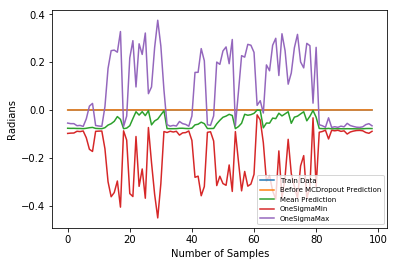

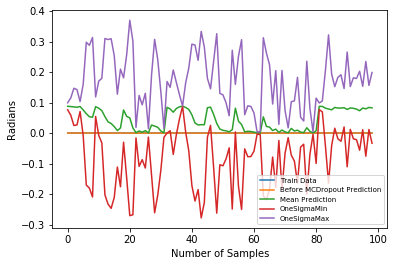

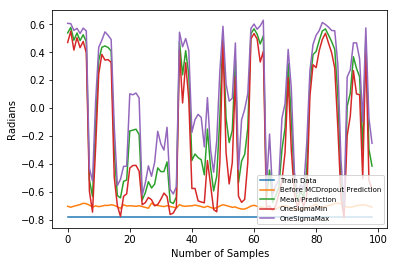

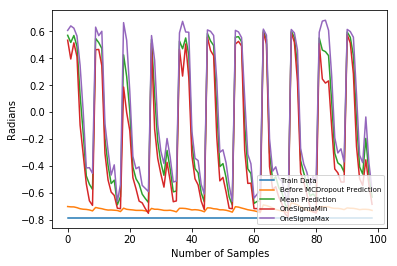

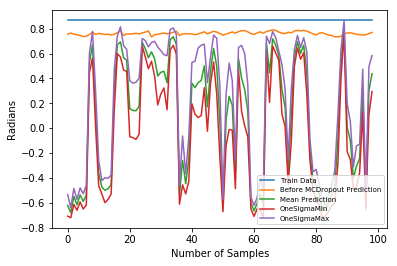

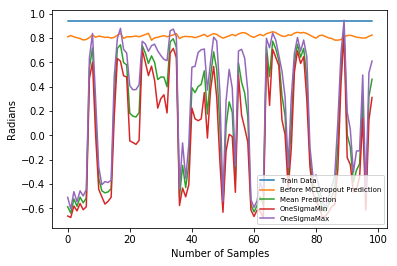

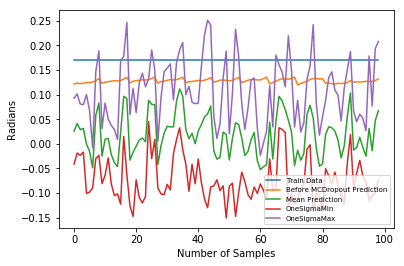

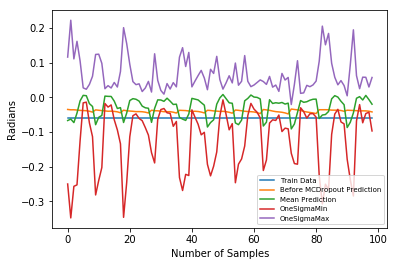

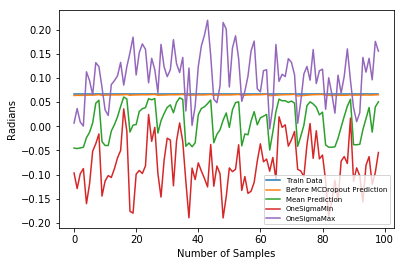

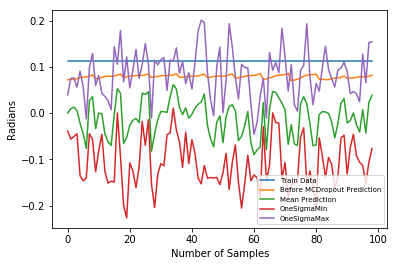

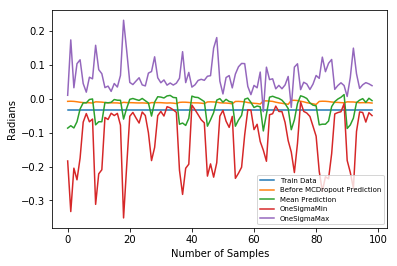

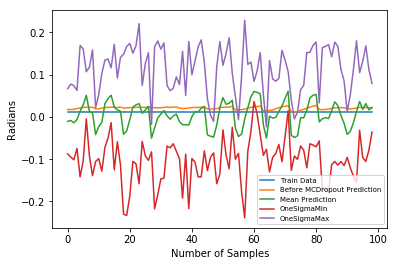

In [8]:
import matplotlib.pyplot as plt

result_mean_df = pd.DataFrame(mean)
result_std_df = pd.DataFrame(std)
result_ground_df = pd.DataFrame(q_unnorm)
result_before_df = pd.DataFrame(q_pred_unnorm)


plot_df = pd.DataFrame()
filename = "Graphs/MCDropout_Results_Q_Feature_"

for i in range (0, 18):
    plot_df['Train Data'] = result_ground_df[i]
    plot_df['Before MCDropout Prediction'] = result_before_df[i]
    plot_df['Mean Prediction'] = result_mean_df[i]
    plot_df['OneSigmaMin'] = result_mean_df[i] - result_std_df[i]
    plot_df['OneSigmaMax'] = result_mean_df[i] + result_std_df[i]

    #print(plot_df.head(4))
    plt.figure()
    ax = plot_df.iloc[0:99].plot()    
    ax.set_xlabel("Number of Samples")
    ax.set_ylabel("Radians")
    plt.legend(loc="lower right", prop={'size':7})
    fileName = filename + str(i)
    plt.savefig(fileName)


In [9]:
item_length = len(mean)

with open('mean.csv', 'w') as mean_file:
  file_writer = csv.writer(mean_file)
  for i in range(item_length):
    file_writer.writerow(mean[[i]])
    
with open('std.csv', 'w') as std_file:
  file_writer = csv.writer(std_file)
  for i in range(item_length):
    file_writer.writerow(std[[i]])


